In [1]:
import importlib
import os
import sys
from copy import deepcopy

import numpy as np
import torch
from torchinfo import summary
import tsai.all as tsai

/home/mercier/bin/anaconda3/envs/python38/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
############## Import modules ##############
sys.path.append('../')

%load_ext autoreload
%autoreload 2

from modules import utils
from modules.attributions.attribution_config import config as default_attr_config
from modules.attributions.attribution_processor import ClassificationProcessor
from modules.compare import auc_compare, generic_compare
from modules.datasets import dataset_utils, pkl_loader, ucr_loader
from modules.networks import model_utils

In [3]:
class OptionParser:
    def __init__(self):
        ########## Global settings #############
        self.verbose = False
        self.seed = 0
        ######### Dataset processing ###########
        self.root_path = "../../data/"
        self.dataset_name =  "CharacterTrajectories"
        self.dataset_file = "dataset.pickle"
        self.normalize = False
        self.standardize = False
        self.validation_split = 0.3
        self.is_channel_first = False
        ######## Dataset modifications #########
        self.use_subset = False
        self.subset_factor = 100.0
        ######### Experiment details ###########
        self.exp_path = None
        self.architecture = 'InceptionTime'
        ####### Perform baseline model #########
        self.load_model = False
        self.save_model = False
        self.epochs = 100
        self.batch_size = 32
        ############ Save details ##############
        self.save_report = False
        self.save_dicts = False
        self.save_plots = False
        self.not_show_plots = False
        self.plot_index = 0
        ########## Attribution details #########
        self.process_attributions = False
        self.not_save_attributions = False
        self.attr_config = None
        self.compute_attributions = False
        self.attr_name = "default"
        self.save_memory = False
        self.plot_attributions = False
        ########## Auc Performance #############
        self.process_aucs = False
        self.compute_aucs = False
        self.plot_aucs = False
        ############ Infidelity ################
        self.process_infidelity = False
        self.compute_infidelity = False
        self.infidelity_scale = 0.1
        self.infidelity_samples = 1000
        self.plot_infidelity = False
        ############ Sensitivity ###############
        self.process_sensitivity = False
        self.compute_sensitivity = False
        self.sensitivity_scale = 0.05
        self.sensitivity_samples = 10
        self.plot_sensitivity = False
        ############# Continuity ###############
        self.process_continuity = False
        self.compute_continuity = False
        self.plot_continuity = False

options = OptionParser()

In [15]:
########## Customize setting ###########
if 1:
    ########## Global settings #############
    options.verbose = True
    ######### Dataset processing ###########
    options.dataset_name =  "CharacterTrajectories"
    options.standardize = True
    ######## Dataset modifications #########
    options.use_subset = True
    options.subset_factor = 10.0
    ######### Experiment details ###########
    options.exp_path = 'dev'
    ####### Perform baseline model #########
    options.load_model = True
    options.save_model = True
    options.architecture = 'InceptionTime'
    ############ Save details ##############
    options.save_report = True
    options.save_dicts = True
    options.save_plots = True
    ########## Attribution details #########
    options.process_attributions = True
    options.compute_attributions = True
    options.attr_name = "default"
    options.plot_attributions = True
    ########## Auc Performance #############
    options.process_aucs = True
    options.compute_aucs = True
    options.plot_aucs = True
    ############ Infidelity ################
    options.process_infidelity = True
    options.compute_infidelity = True
    options.plot_infidelity = True
    ############ Sensitivity ###############
    options.process_sensitivity = True
    options.compute_sensitivity = True
    options.plot_sensitivity = True
    ############# Continuity ###############
    options.process_continuity = True
    options.compute_continuity = True
    options.plot_continuity = True

In [16]:
########## Global settings #############
np.random.seed(options.seed)
torch.manual_seed(options.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dir, result_dir = utils.maybe_create_dirs(
    options.dataset_name, root='../../', dirs=['models', 'results'],
    exp=options.exp_path, return_paths=True, verbose=options.verbose)

Found existing directory: ../../models/baseline/anomaly_new
Found existing directory: ../../results/baseline/anomaly_new


In [17]:
######### Dataset processing ###########
dataset_dict = ucr_loader.get_datasets(options.root_path, prefix='**/')
split_id = None
try:
    trainX, trainY, testX, testY = ucr_loader.load_data(
        dataset_dict[options.dataset_name])
    valX, valY = None, None
except:
    trainX, trainY, valX, valY, testX, testY = pkl_loader.load_data(
        os.path.join(options.root_path, options.dataset_name,
                        options.dataset_file),
        is_channel_first=options.is_channel_first)
if valX is not None:
    trainX, trainY, split_id = dataset_utils.fuse_train_val(
        trainX, trainY, valX, valY)
trainX, trainY, testX, testY = dataset_utils.preprocess_data(
    trainX, trainY, testX, testY, normalize=options.normalize,
    standardize=options.standardize, channel_first=True)
if split_id is None:
    trainX, trainY, valX, valY = dataset_utils.perform_datasplit(
        trainX, trainY, test_split=options.validation_split)
else:
    trainX, trainY, valX, valY = dataset_utils.unfuse_train_val(
        trainX, trainY, split_id)
channels, timesteps = trainX.shape[1:]
n_classes = len(np.unique(trainY))

if options.verbose:
    print('TrainX:', trainX.shape)
    print('ValX:', valX.shape)
    print('TestX:', testX.shape)
    print('Classes:', n_classes)

TrainX: (35000, 3, 50)
ValX: (15000, 3, 50)
TestX: (10000, 3, 50)
Classes: 2


In [18]:
##### Subset creation for attr #########
if options.use_subset:
    sub_testX, sub_testY, sub_ids = dataset_utils.sub_sample(
        testX, testY, options.subset_factor)
else:
    sub_testX, sub_testY, sub_ids = testX, testY, np.arange(
        testX.shape[0])

In [19]:
######### Data loader creation #########
trainloader = model_utils.create_dataloader(
    trainX, trainY, batch_size=options.batch_size, shuffle=True,
    drop_last=False, num_workers=8)
valloader = model_utils.create_dataloader(
    valX, valY, batch_size=options.batch_size, shuffle=False,
    drop_last=False, num_workers=8)

In [20]:
######### Model architecture ###########
architecture_func = {'InceptionTime': tsai.InceptionTime}

In [21]:
####### Perform baseline model #########
model_setup = options.architecture + '_batch-' + \
    str(options.batch_size)
model_path = os.path.join(
    model_dir, model_setup + '.pt') if options.save_model \
    or options.load_model else None

model = architecture_func[options.architecture](
    channels, n_classes).to(device)
if options.verbose:
    print(summary(model, input_size=(
        options.batch_size, channels, timesteps)))
    
if os.path.exists(model_path) and options.load_model:
    model.load_state_dict(torch.load(model_path))
else:
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=5, verbose=options.verbose)

    model_utils.train(model, trainloader, valloader, options.epochs,
                        optimizer, criterion, lr_scheduler=scheduler,
                        early_patience=10, path=model_path,
                        verbose=options.verbose)
model.eval()

Layer (type:depth-idx)                        Output Shape              Param #
InceptionTime                                 --                        --
├─InceptionBlock: 1                           --                        --
│    └─ModuleList: 2-1                        --                        --
│    └─ModuleList: 2-2                        --                        --
├─InceptionBlock: 1-1                         [32, 128, 50]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─InceptionModule: 3-1              [32, 128, 50]             69,056
│    │    └─InceptionModule: 3-2              [32, 128, 50]             77,056
│    │    └─InceptionModule: 3-3              [32, 128, 50]             77,056
│    └─ModuleList: 2-2                        --                        --
│    │    └─ConvBlock: 3-4                    [32, 128, 50]             640
│    └─Add: 2-3                               [32, 128, 50]             --
│    └─

InceptionTime(
  (inceptionblock): InceptionBlock(
    (inception): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxconvpool): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (concat): Concat(dim=1)
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (1): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
        (convs): ModuleList(
        

In [22]:
############# Evaluation ###############
report_path = os.path.join(
    result_dir, model_setup + '_report.txt') if options.save_report \
    else None
preds = model_utils.predict(model, torch.Tensor(testX),
                                options.batch_size).numpy()
utils.compute_classification_report(
    testY, preds, save=report_path, verbose=options.verbose, store_dict=options.save_dicts)

              precision    recall  f1-score   support

           0     0.9877    0.9970    0.9923      8304
           1     0.9845    0.9393    0.9614      1696

    accuracy                         0.9872     10000
   macro avg     0.9861    0.9681    0.9769     10000
weighted avg     0.9872    0.9872    0.9871     10000



In [23]:
############ Evaluate subset ###########
if options.use_subset:
    subset_folder = os.path.join(
        result_dir, model_setup, 'subset_' + str(options.subset_factor))
    os.makedirs(subset_folder, exist_ok=True)
    np.save(os.path.join(subset_folder, 'Sub_ids.npy'), sub_ids)
    subset_report_path = os.path.join(subset_folder, 'acc_report.txt') \
        if options.save_report else None
    preds = model_utils.predict(model, torch.Tensor(sub_testX),
                                options.batch_size).numpy()
    utils.compute_classification_report(
        sub_testY, preds, save=subset_report_path, verbose=options.verbose,
        store_dict=options.save_dicts)

              precision    recall  f1-score   support

           0     0.9750    1.0000    0.9873        78
           1     1.0000    0.9091    0.9524        22

    accuracy                         0.9800       100
   macro avg     0.9875    0.9545    0.9699       100
weighted avg     0.9805    0.9800    0.9797       100



Prepared: FeatureAblation...GuidedBackprop...IntegratedGradients...Lime...Occlusion...Timereise...Done
Loaded file: ../../models/baseline/anomaly_new/InceptionTime_batch-32/subset_100.0/default/Occlusion_attr.npy
Loaded file: ../../models/baseline/anomaly_new/InceptionTime_batch-32/subset_100.0/default/FeatureAblation_attr.npy
Loaded file: ../../models/baseline/anomaly_new/InceptionTime_batch-32/subset_100.0/default/IntegratedGradients_attr.npy
Loaded file: ../../models/baseline/anomaly_new/InceptionTime_batch-32/subset_100.0/default/GuidedBackprop_attr.npy
Loaded file: ../../models/baseline/anomaly_new/InceptionTime_batch-32/subset_100.0/default/Lime_attr.npy
Loaded file: ../../models/baseline/anomaly_new/InceptionTime_batch-32/subset_100.0/default/Timereise_attr.npy


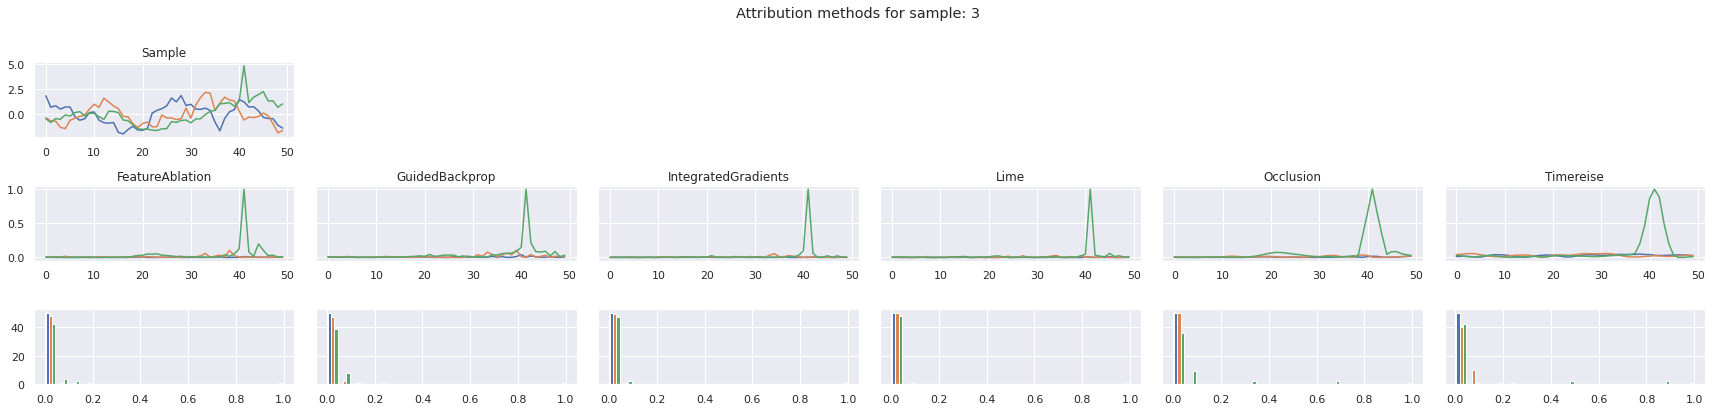

In [26]:
from modules.attributions.attribution_config_dev import config as default_attr_config # debug only

######### Attribution ##################
if options.process_attributions:
    config_file = default_attr_config
    if options.attr_config is not None:
        config_spec = importlib.util.spec_from_file_location(
            "attr_config", options.attr_config)
        config_mod = importlib.util.module_from_spec(config_spec)
        config_spec.loader.exec_module(config_mod)
        config_file = config_mod.config
    attr_dir = None
    complete_attr_name = 'complete'
    if options.use_subset:
        complete_attr_name = 'subset_' + str(options.subset_factor)
    complete_attr_name = os.path.join(complete_attr_name,
                                        options.attr_name)
    attr_result_dir = os.path.join(result_dir, model_setup,
                                    complete_attr_name)
    os.makedirs(attr_result_dir, exist_ok=True)
    if not options.not_save_attributions:
        attr_dir = os.path.join(
            model_dir, model_setup, complete_attr_name)
        os.makedirs(attr_dir, exist_ok=True)
        if options.use_subset:
            np.save(os.path.join(attr_dir, 'Sub_ids.npy'), sub_ids)
    attrProcessor = ClassificationProcessor(
        model, trainX.shape[1:], config_file,
        save_memory=options.save_memory, attr_dir=attr_dir,
        load=not options.compute_attributions, verbose=options.verbose)

    if options.compute_attributions:
        if options.verbose:
            print('Use %s samples for attribution' % sub_ids.shape[0])
        attrProcessor.compute_all_attributions(sub_testX, sub_testY,
                                                attr_dir)

    if options.plot_attributions:
        attrProcessor.plot_approaches(sub_testX, index=options.plot_index,
                                        not_show=options.not_show_plots,
                                        save_path=attr_result_dir
                                        if options.save_plots else None)

"{'del': {'accuracy': {'GuidedBackprop': 0.06575091575091575, 'IntegratedGradients': 0.09523809523809523, 'Timereise': 0.06025641025641024}, 'macro avg/f1-score': {'GuidedBackprop': 0.05736901986901988, 'IntegratedGradients': 0.06492421159087824, 'Timereise': 0.04914266170676426}, 'weighted avg/f1-score': {'GuidedBackprop': 0.06462759462759464, 'IntegratedGradients': 0.08626984126984127, 'Timereise': 0.05929181929181928}}, 'ins': {'accuracy': {'GuidedBackprop': 0.8487179487179487, 'IntegratedGradients': 0.8538461538461538, 'Timereise': 0.8406593406593407}, 'macro avg/f1-score': {'GuidedBackprop': 0.8309204023489738, 'IntegratedGradients': 0.8328708328708329, 'Timereise': 0.8154682618968333}, 'weighted avg/f1-score': {'GuidedBackprop': 0.8465201465201465, 'IntegratedGradients': 0.8527472527472527, 'Timereise': 0.8378815628815629}}}"


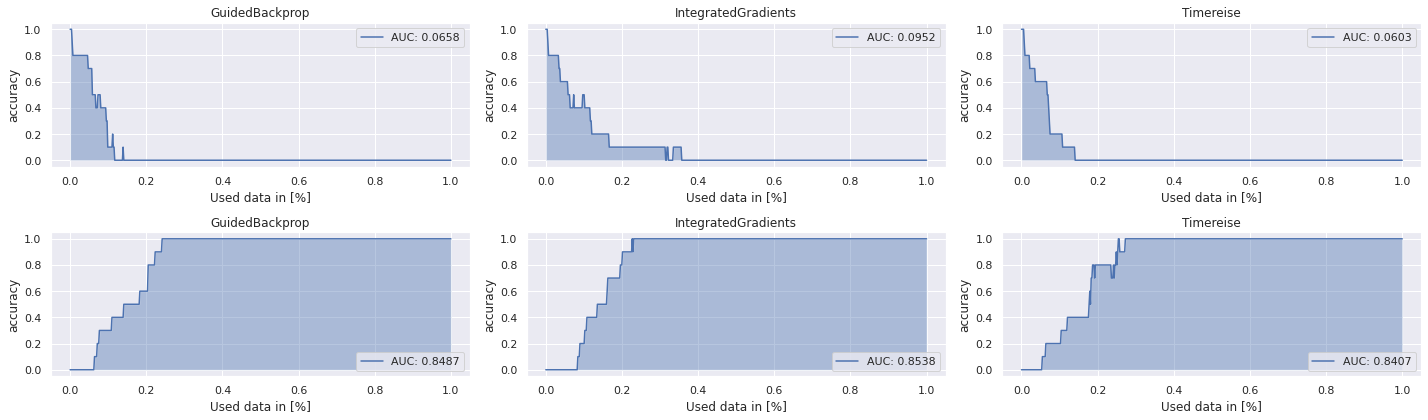

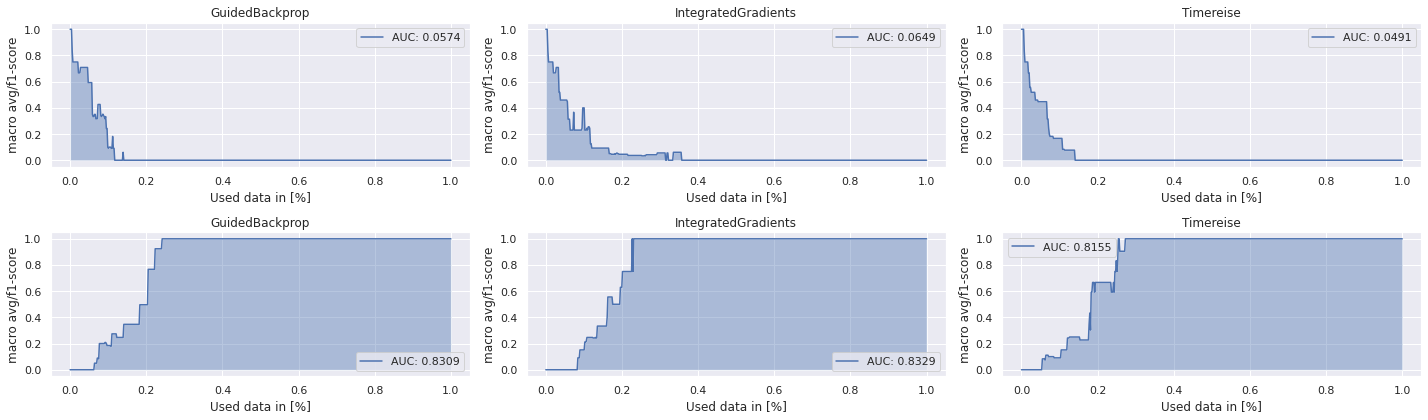

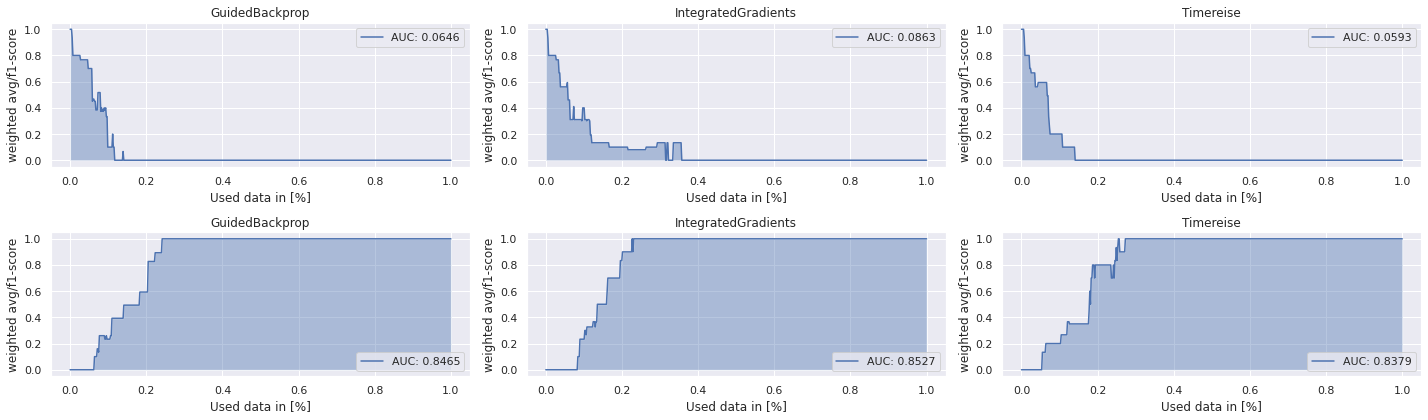

In [30]:
######### Auc Performance ##############
if options.process_aucs:
    auc_path = os.path.join(attr_result_dir, 'AUC.pickle')
    if options.compute_aucs:
        auc_report = auc_compare.compute_auc(
            model, attrProcessor, sub_testX, sub_testY, 
            batch_size=options.batch_size)
        utils.save_pickle(auc_report, auc_path)
        auc_report_path = auc_path.replace('.pickle', '.txt') \
            if options.save_report else None
        utils.get_pretty_dict(
            auc_report['summary'], sort=True, save=auc_report_path,
            verbose=options.verbose)
    else:
        auc_report = utils.load_pickle(auc_path)
        if options.verbose:
            print(auc_report['summary'])

    if options.plot_aucs:
        auc_compare.plot_auc(
            auc_report, not_show=options.not_show_plots,
            save_path=attr_result_dir if options.save_plots else None)

"{'GuidedBackprop': {'mean': 0.19175783, 'std': 0.4355712}, 'IntegratedGradients': {'mean': 0.18359138, 'std': 0.4318634}, 'Timereise': {'mean': 0.19061284, 'std': 0.4325986}}"


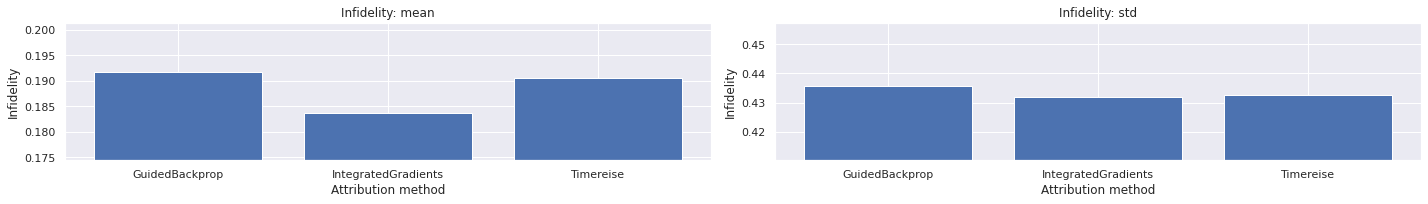

In [24]:
############## Infidelity ##############
if options.process_infidelity:
    inf_path = os.path.join(attr_result_dir, 'Infidelity_%s_%s.pickle' % (
        options.infidelity_scale, options.infidelity_samples))
    if options.compute_infidelity:
        infidelity_report = generic_compare.compute_inf_sens(
            attrProcessor, sub_testX, sub_testY,
            scale=options.infidelity_scale,
            n_perturb_samples=options.infidelity_samples,
            mode='Infidelity', batch_size=options.batch_size)
        utils.save_pickle(infidelity_report, inf_path)
        inf_report_path = inf_path.replace('.pickle', '.txt') \
            if options.save_report else None
        utils.get_pretty_dict(infidelity_report['summary'], sort=True,
                              save=inf_report_path, verbose=options.verbose)
    else:
        infidelity_report = utils.load_pickle(inf_path)
        if options.verbose:
            print(infidelity_report['summary'])

    if options.plot_infidelity:
        generic_compare.plot(
            infidelity_report, mode='Infidelity',
            scale=options.infidelity_scale,
            n_perturb_samples=options.infidelity_samples,
            not_show=options.not_show_plots,
            save_path=attr_result_dir if options.save_plots else None)

Prepared: FeatureAblation...GuidedBackprop...IntegratedGradients...Lime...Occlusion...Timereise...Done


/home/mercier/bin/anaconda3/envs/python38/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/mercier/bin/anaconda3/envs/python38/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:60: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


"{'GuidedBackprop': {'mean': 0.040626924, 'std': 0.17823558}, 'IntegratedGradients': {'mean': 0.06646610368170829, 'std': 0.23069221750137894}, 'Timereise': {'mean': 0.005191202, 'std': 0.016959071}}"


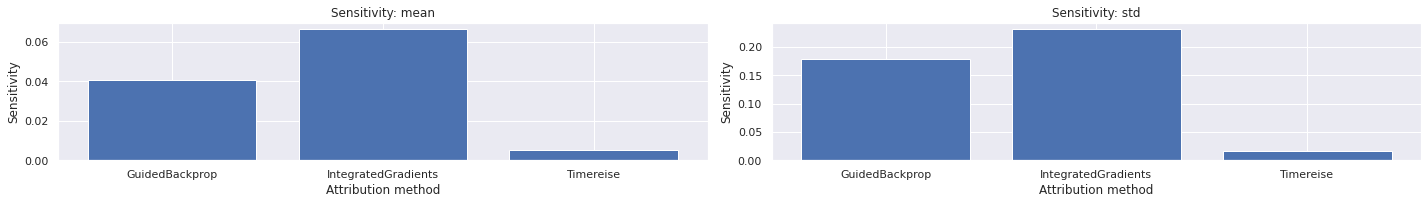

In [24]:
############ Sensitvitity ##############
if options.process_sensitivity:
    sens_path = os.path.join(attr_result_dir, 'Sensitivity_%s_%s.pickle' 
                                % (options.sensitivity_scale,
                                options.sensitivity_samples))
    if options.compute_sensitivity:
        sens_config_file = deepcopy(config_file)
        try:
            sens_config_file['Timereise']['config']['load'] = True
        except:
            pass
        sensProcessor = ClassificationProcessor(
                model, trainX.shape[1:], sens_config_file,
                attr_dir=attr_dir, load=False, save=False,
                verbose=options.verbose)
        sensitivity_report = generic_compare.compute_inf_sens(
            sensProcessor, sub_testX, sub_testY,
            scale=options.sensitivity_scale,
            n_perturb_samples=options.sensitivity_samples,
            mode='Sensitivity', batch_size=options.batch_size)
        utils.save_pickle(sensitivity_report, sens_path)
        sens_report_path = sens_path.replace('.pickle', '.txt') \
            if options.save_report else None
        utils.get_pretty_dict(
            sensitivity_report['summary'], sort=True,
            save=sens_report_path, verbose=options.verbose)
    else:
        sensitivity_report = utils.load_pickle(sens_path)
        if options.verbose:
            print(sensitivity_report['summary'])

    if options.plot_sensitivity:
        generic_compare.plot(
            sensitivity_report, mode='Sensitivity', 
            scale=options.sensitivity_scale,
            n_perturb_samples=options.sensitivity_samples,
            not_show=options.not_show_plots,
            save_path=attr_result_dir if options.save_plots else None)

"{'GuidedBackprop': {'mean': 0.03563815, 'std': 0.026010767}, 'IntegratedGradients': {'mean': 0.03792294672512499, 'std': 0.022184482633794498}, 'Timereise': {'mean': 0.013280798, 'std': 0.011991416}}"


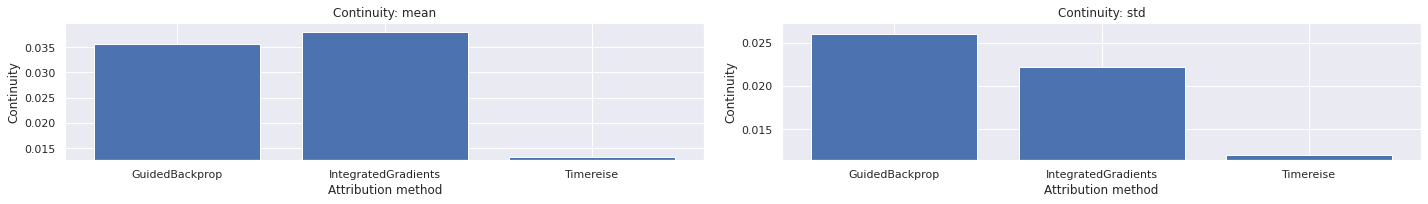

In [30]:
options.process_continuity = True
options.compute_continuity = True
options.plot_continuity = True

############## Continuity ##############
if options.process_continuity:
    con_path = os.path.join(attr_result_dir, 'Continuity.pickle')
    if options.compute_continuity:
        continuity_report = generic_compare.compute_continuity(
            attrProcessor)
        utils.save_pickle(continuity_report, con_path)
        con_report_path = con_path.replace('.pickle', '.txt') \
            if options.save_report else None
        utils.get_pretty_dict(continuity_report['summary'], sort=True,
                              save=con_report_path, verbose=options.verbose)
    else:
        continuity_report = utils.load_pickle(con_path)
        if options.verbose:
            print(continuity_report['summary'])

    if options.plot_continuity:
        generic_compare.plot(
            continuity_report, scale=options.infidelity_scale,
            n_perturb_samples=options.infidelity_samples,
            mode='Continuity', not_show=options.not_show_plots,
            save_path=attr_result_dir if options.save_plots else None)

In [ ]:
######### Begin Not in py ##############